# COMP90042 Assignment #1: Sentiment analysis for tweets

Student Name: Cong Yue

Student ID: 682020

***Notice***: 

****I zipped train.json, dev.json and test.json with this script. If you demonstrate it, please run in the extracted directory or place all json file and this script in the same directory and then run****

## General info

<b>Due date</b>: 5pm, Mon April 12

<b>Submission method</b>: see LMS

<b>Submission materials</b>: completed copy of this ipython notebook

<b>Late submissions</b>: -10% per day, no late submissions after the first week

<b>Marks</b>: 25% of mark for class

<b>Overview</b>: For this project, you'll be building a 3-way polarity classification system for tweets, using a logistic regression classifier, BOW features, as well as polarity lexicons built from external sources. A key focus of this project is critical analysis and experimental evaluation, for which you will need to report on the relative merits of various options. 

<b>Materials</b>: See the main class LMS page for information on the basic setup required for this class, including an iPython notebook viewer and the python packages NLTK, Numpy, Scipy, Matplotlib, Sci-kit Learn, and Gemsim. In particular, if you are not using a lab computer which already has it installed, we recommend installing all the data for NLTK, since you will need various parts of it to complete this assignment. You can also use any Python build-in packages, but do not use any other 3rd party packages; if your iPython notebook doesn't run on the marker's machine, you will lose marks. You are encouraged to use the iPython notebooks released for this class as well as other online documentation to guide your responses, but you should not copy directly from any source. The only other data you will need is three sets of tagged tweets, the first two of which (training and dev) were released at the same time as this notebook, and a third set (test) which will be made available about a week before the assignment is due, see Final Testing below. This data comes from the recent SemEval 2016 shared task. Do not distribute this data indiscriminately (i.e. put it on a public website), you should use it only for this assignment, and delete it afterwards. The corpus is comprised of unfiltered text from the web, and may include offensive or objectionable material. This reflects the general composition of the web and the general challenges present in web based text analysis. The University of Melbourne takes no responsibility for opinions expressed in the corpus, nor takes any responsibility for offence caused by these documents.

<b>Evaluation</b>: Your iPython notebook should run end-to-end without any errors in a reasonable amount of time (less than 10 minutes on a lab desktop), and you must follow all instructions provided below, including specific implementation requirements. You will be marked not only on the correctness of your methods, but also on your explanation and analysis. Please do not change any of instruction text in the notebook. Where applicable, leave the output cells in the code, particularly when you are commenting on that output. You should add your answers and code by inserting a markdown cell between every major function or other block of code explaining its purpose or anywhere a result needs to be discussed (see the class notebooks for examples). Note that even if you do something wrong, you might get partial credit if you explain it enough that we can follow your reasoning, whereas a fully correct assignment with no text commentary will not receive a passing score. You will not be marked directly on the performance of your final classifier, but each of the steps you take to build it should be reasonable and well-defended.

<b>Updates</b>: Any major changes to the assignment will be announced via LMS. Minor changes and clarifications will be announced in the forum on LMS, we recommend you check the forum regularly.

<b>Academic Misconduct</b>: For most people, collaboration will form a natural part of the undertaking of this project, and we encourage you to discuss it in general terms with other students. However, it is still an individual task, and so reuse of code or other instances of clear influence will be considered cheating. We will be checking submissions for originality and will invoke the University’s <a href="http://academichonesty.unimelb.edu.au/policy.html">Academic Misconduct policy</a> where inappropriate levels of collusion or plagiarism are deemed to have taken place.


## Preprocessing

<b>Instructions</b>: Your first task is to carry out preprocessing on the tweets. Use the code below as a starter. Each line of the input files is a json including the tweet and the label (and the tweet id), this code just loads them into a list without any preprocessing. Note that for the labels, 1 = positive, 0 = neutral, -1 = negative. Here is a list of things your preprocessing code must do:

<ul>
<li>Segment into sentences: Use NLTK punkt sentence segmenter</li>
<li>Tokenize sentences: Use the NLTK regex WordPunct tokenizer</li>
<li>Lowercase all words</li>
<li>Remove Twitter usernames: Usernames on twitter begin with @</li>
<li>Remove URLs: URLs start with http</li> 
<li>Remove any hashtags from their original location in the tweet, tokenize them, and add them as a separate sentences with the hash tag removed: for tokenization, use capitalized letters when they occur (e.g. #RefugeesWelcome -> Refugees Welcome), or when there is no capitalization (#refugeeswelcome -> refugees welcome) use the MaxMatch algorithm and the list of English words included in NLTK (nltk.corpus.words.words()). Two notes about the English word list: 1. you should convert it to a python set before you use it (sets are hashed, so you get much quicker lookup) 2. It contains only base forms, so you will need to lemmatize words before you look them up.</li>
</ul>

You can do these in almost any order you like, but it may be useful to do the main segmentation/tokenization last (or almost last), since for the other tasks it is easier to deal with the raw string rather than a list of tokens. The use of regular expressions is recommended, but not required.



In [38]:
import json
import re
import nltk

words = nltk.corpus.words.words()
words = frozenset(words)

username_url_pattern = re.compile('@\S+|http://\S+|https://\S+')
hashtag_pattern = re.compile('#\w+')
cap_token_pattern = re.compile('[A-Z][a-z0-9_]*')

def preprocess(tweet):
    # remove usernames, URLs
    tweet = re.sub(username_url_pattern, '', tweet).strip()
    
    # remove hashtags
    tweet = remove_hashtags(tweet, words)
    
    # lowercase all words
    tweet = tweet.lower()

    # segment into sentences
    sgmter = nltk.data.load('tokenizers/punkt/english.pickle')
    tweet = sgmter.tokenize(tweet)
    
    # tokenize sentences
    tokenizer = nltk.tokenize.regexp.WordPunctTokenizer()
    tweet = [tokenizer.tokenize(sentence) for sentence in tweet]
    
    return tweet

**Explanations**: 

It is easier to do case transformation, username and URL removal than sentence segmentation and tokenization. But the case transformation has to be set after hashtag removal, because when removing hashtags, it needs the feature of capitalized letter to tokenize sentence. So I set username and URL removal firstly, then hashtag removal and case transformation, finally do the segmentation and tokenization by using nltk. The order of preprocessing tasks is as the following list starts with **bullet point**

* Remove Twitter usernames
* Remove URLs

The instruction requires to remove URLs start with **http**, we thought the aim is to remove non-readable text. So we consider it to be reasonable to remove **https** as well.

When it comes to hashtags removal, it is not only character removal (#), but also tokenization and lemmatization need to be taken into account. However, tokenization here is different from tokenizing sentences by using nltk, we need to apply max match algorithm, so we operate hashtags' removal ahead of general sentence tokenization. There are two advantages, one is that we do not need to iterates all tokens inside a sentence to find hashtags, which means we reduce the number of iteration; the second is that after nltk regex tokenization, hashtag will be seperated with tagged sentences, which makes the sentence hard to find and tokenize. 

* Remove and tokenize hashtags.
* Lowercase all words
* Segment into sentences
* Tokenize sentences

We pre-compile the regex pattern to speed up the process. This is because we avoid compiling pattern inside the iteration, which is time-consuming. 



In [39]:
def remove_hashtags(tweet, words):
    tagged_sentences = re.findall(hashtag_pattern, tweet)
    for sentence in tagged_sentences:
        # start from pos 1 to ignore the first '#' character.
        target_sentence = sentence[1:]
        # Use capitalized letter when it occurs
        cap_tokens = re.findall(cap_token_pattern, target_sentence)
        if cap_tokens:
            untagged_sentence = ' '.join(cap_tokens)
        # use max match and word dictionary to segment hashtagged topics
        else:
            result = max_match(target_sentence, words)
            # remove extra space that produced by max_match at the end.
            untagged_sentence = result.strip()
        # replace tagged sentence with tokenized sentence
        tweet = re.sub(sentence, untagged_sentence, tweet)
        
    return tweet

def max_match(sentence, dic):
    if len(sentence) == 0:
        return ''
    
    for idx in xrange(len(sentence),0,-1):
        # back traverse the sentence.
        token = sentence[:idx]
        reminder = sentence[idx:]
        # compare using lemmatized tokens
        lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
        lemma = lemmatizer.lemmatize(token)
        if lemma in dic:
            return '%s %s' % (token, max_match(reminder, dic))
        
    # no one in dic, one character word
    token = sentence[:1]
    reminder = sentence[1:]
    return '%s %s' % (token, max_match(reminder, dic))

**Explanation**:

We seperate hashtag removal into 3 sections:

1. Find substring that starts with '#' followed by printable characters. For single '#' characters and '#' followed by non-alphabet characters, we do not regard them as hashtag for a topic.
2. Check if there are capital letters that can seperate the target sentence
3. If there is no capital letter, seperate target sentence by using max_match function and word dictionary.

We implement recursive version of max match algorithm, and compare the lemma with word in dictionary as required in **instruction**

In [40]:
def preprocess_file(filename):
    tweets = []
    labels = []
    f = open(filename)
    for line in f:
        tweet_dict = json.loads(line)
        tweets.append(preprocess(tweet_dict["text"]))
        labels.append(int(tweet_dict["label"]))
    return tweets,labels

<b>Instructions</b>: Once your basic preprocessing module is working, run it on the training set and have it print out 10 examples where your system identified a hashtag with more than one word inside; print out both the original tweet string as well as result after preprocessing. It's okay if you have to duplicate some code from above to do this. Point out any errors you see in the preprocessing, and discuss possible solutions; these can be related to the hashtags, or any other errors you see. You do not have to fix the errors unless they actually indicate a actual bug in your code (at which point you should go back to the previous section, fix the code, and print out the samples again).

In [77]:
idx = 0 # tweet index in tweets, map each processed tweet with original tweet
ptr = 0 # pointer to tweet that has hashtags.
tweets, labels = preprocess_file('train.json')
f = open('./train.json')
for line in f:
    # print out 10 examples with hashtags
    if ptr >= 10:
         break
    tweet_dict = json.loads(line)
    if re.match(hashtag_pattern, tweet_dict['text']):
        print '%s. ORIGINAL TWEET [%s]: %s' % (ptr, idx, tweet_dict['text'])
        print '%s. PROCESSED TWEET [%s]: %s' % (ptr, idx, tweets[idx])
        print 
        ptr = ptr + 1
    idx = idx + 1

0. ORIGINAL TWEET [16]: #teens @BillGates 1st company failed miserably. When Gates & @PaulGAllen tried to sell the product it wouldn't work #nevergiveup @Microsoft
0. PROCESSED TWEET [16]: [[u'teens', u'1st', u'company', u'failed', u'miserably', u'.'], [u'when', u'gates', u'&', u'tried', u'to', u'sell', u'the', u'product', u'it', u'wouldn', u"'", u't', u'work', u'never', u'give', u'up']]

1. ORIGINAL TWEET [17]: #Vote for @AIESEC to become the 10th Global non profit partner of @Microsoft for us to #UpgradeYourWorld together. @AIESECGermany
1. PROCESSED TWEET [17]: [[u'vote', u'for', u'to', u'become', u'the', u'10th', u'global', u'non', u'profit', u'partner', u'of', u'for', u'us', u'to', u'upgrade', u'your', u'world', u'together', u'.']]

2. ORIGINAL TWEET [70]: #llvm 3.7 is the 2nd release to incorporate contributions from my team at @microsoft. Congrats to all involved! :) https://t.co/IUtbNxonfw
2. PROCESSED TWEET [70]: [[u'l', u'l', u'v', u'm', u'3', u'.', u'7', u'is', u'the', u'2nd

**Explanation**: There is an error in the 503th (start from 0, also the 6th from example above) tweet. There is an error on regular expression pattern of username removal. The original tweet has '@Angie_Merkel', the result only remove 'Angie' and left '_Merkel'. The original regex is '@[a-zA-Z0-9]+', the solution is '@\S+'.

<b>Instructions</b>: The next step will be to convert each of your preprocessed tweets into a feature dictionary, that is, a python dictionary where each entry corresponds to a feature and its value. At this stage, you should just build a bag-of-word feature dict, though you must allow for two possible options: one is to remove stopwords (using the NLTK stopword list), and the other is to remove words appearing <em>less</em> than n times across the entire training set (n<=0 should have no effect). The outer function (convert_to_feature dicts) should take the list of tweets resulting from the preprocess_file, and return a list of feature dictionaries in the same order (so they correspond to the label)

In [42]:
def convert_to_feature_dicts(tweets,remove_stop_words=set(),n=0):
    feature_dicts = []
    # record the occurance of tokens based on entire training set
    global_feature_dict = {}
    for tweet in tweets:
        feature_dict = {}
        for sentence in tweet:
            for token in sentence:
                # skip stop words
                if token in remove_stop_words:
                    continue 
                # add token into dict
                if token not in feature_dict:
                    feature_dict.setdefault(token, 1)
                else:
                    feature_dict[token] = feature_dict[token] + 1
                # add token to global dictionary preparing for removing less frequency tokens
                if token not in global_feature_dict:
                    global_feature_dict.setdefault(token, 1)
                else:
                    global_feature_dict[token] = global_feature_dict[token] + 1
        feature_dicts.append(feature_dict)
    
    if n <= 0:
        return feature_dicts
    
    # remove feature that occur less than n times
    for idx, dic in enumerate(feature_dicts):
        for feature in dic.keys():
            if global_feature_dict[feature] <= n:
                feature_dicts[idx].pop(feature)
             
    return feature_dicts

**Explanation**: 

According to my implementation, a tweet in tweets is a list and each sentence in a tweet is a list, so I need 3 nested for loop to traverse every tokens in a sentence.

`Remove stop words`

Build a set (stopwords) of stop words, skip next actions if tokens are in stopwords.

`Remove less frequent words`

Build a global dictionary that records all words' fequency based on entire training set. Use a for loop to remove less frequent feature from feature_dicts one by one.

## Tuning and classifying

<b>Instructions</b>: Using the functions you've written, you should produce lists of feature dictionaries for both training and development sets; for the training set, remove stopwords and all words that appear only once (do <em>not</em> this for the dev set). Using scikit learn, convert the data to the sparse representation used for training classifiers.

In [68]:
stopwords = frozenset(nltk.corpus.stopwords.words('english'))

train_set = 'train.json'
train_tweets, train_labels = preprocess_file(train_set)
train_feature_dicts = convert_to_feature_dicts(train_tweets, stopwords, 1)

dev_set = 'dev.json'
dev_tweets, dev_labels = preprocess_file(dev_set)
dev_feature_dicts = convert_to_feature_dicts(dev_tweets)

from sklearn.feature_extraction import DictVectorizer
vectorizer = DictVectorizer()
train_data = vectorizer.fit_transform(train_feature_dicts)
dev_data = vectorizer.transform(dev_feature_dicts)

import numpy as np
train_labels = np.asarray(train_labels)
dev_labels = np.asarray(dev_labels)

<b>Instructions</b>: Now, tune a decision tree classifier using accuracy in the development set as the evaluation metric. For this, you need to consider at least 2 parameters of the model likely to influence performance and which make sense in this context; you should read the documentation for the classifier on sci-kit learn website to learn what these parameters are. For any binary or categorical parameters, you should just consider all options. For numerical values, you should start by keep other settings on default and just randomly try a wide range, looking for values above which there is a steep drop-off in performance, or, alternatively, no effect on performance at all (you don't need to show this process in the notebook).  Remember that some parameters should be tested on a logarithmic scale. Once you're fairly confident of a good range for the parameter, divide it up into at least 5 steps (but no more than 10), and carry out a grid search, which is to say an exhaustive exploration of all parameter options within the limits you've set (this should be included in the notebook). Identify the best parameter values, and discuss the influence of the parameters on performance in the development set. Do you think some values of the parameters are resulting in overfitting?  

In [76]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier(criterion='gini',)

# grid search params
param_grid = {'max_features': [.9, .99],
             'max_leaf_nodes': [2,10,50]}

# accuracy to params dictionary
acc_score_dict = {}
for param_out in param_grid['max_features']:
    for param_in in param_grid['max_leaf_nodes']:
        clf.set_params(max_features=param_out,
                       max_leaf_nodes=param_in)
        clf.fit(train_data, train_labels)
        preds = clf.predict(dev_data)
        print '[max_features: %s,    max_leaf_nodes: %s]' % (param_out, param_in)
        print 'Model: %s' % clf
        acc = accuracy_score(dev_labels, preds)
        print 'Accuracy: %s\n' % acc
        acc_score_dict.setdefault(acc, (param_out, param_in))
print 'The best parameters are: max_features - %s, \tmax_leaf_nodes - %s' % \
        (acc_score_dict[max(acc_score_dict.keys())][0], 
        acc_score_dict[max(acc_score_dict.keys())][1])

[max_features: 0.9,    max_leaf_nodes: 2]
Model: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=0.9, max_leaf_nodes=2, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Accuracy: 0.44669218152

[max_features: 0.9,    max_leaf_nodes: 10]
Model: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=0.9, max_leaf_nodes=10, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Accuracy: 0.48277747403

[max_features: 0.9,    max_leaf_nodes: 50]
Model: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=0.9, max_leaf_nodes=50, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitt

**Explanation**:

The best parameter values of the pair params we choose is: `max_features`: 0.9, `max_leaf_nodes`: 50 

The value of ***max_features*** decides what percentage of total features (in our case it is 10890) are used to split nodes. The more features are used for spliting a node, the more the tree tend to overfit, but too small of that value  underfit the groud truth on the contrary. So I choose '0.9', most of features for each node spliting, and '0.99', almost all of features to check whether it overfits. The result report above gives the positive answer, every example that max_features=0.99 has lower accuracy than the corresponding example ( example holding max_leaf_nodes static).

The value of ***max_leaf_nodes*** defines the stop criteria of the growth of tree. The deeper the tree grows, the smaller the node that leaf contain, which means the more granular the model fit the observations. This is bad, the structure risk rises. As we can see from the result on development set, the smaller the value, the lower of the accuracy. I still do not have a clue about which is better, 10 or 50, and the grid search result gives me the answer: 50. However, this is not the larger the better. It underfits if the value is too small, because the tree depth will be very short.

<b>Instructions</b>: Carry out the same tuning process with the logistic regression classifier. Compare the performance of the two classifiers to each other, and to the most common class baseline. How are the classifiers doing? Is this a challenging task?

In [45]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs',
                         multi_class='multinomial')

# grid search params
param_grid = {'C': [0.01, 0.1, 1],
             'max_iter': [10, 100]}

# accuracy to params dictionary
acc_score_dict = {}
for param_out in param_grid['C']:
    for param_in in param_grid['max_iter']:
        clf.set_params(C=param_out,
                       max_iter=param_in)
        clf.fit(train_data, train_labels)
        preds = clf.predict(dev_data)
        print '[C: %s,    max_iter: %s]' % (param_out, param_in)
        print 'Model: %s' % clf
        acc = accuracy_score(dev_labels, preds)
        print 'Accuracy: %s\n' % acc
        acc_score_dict.setdefault(acc, (param_out, param_in))
print 'The best parameters are: C - %s, \tmax_iter - %s' % \
        (acc_score_dict[max(acc_score_dict.keys())][0], 
        acc_score_dict[max(acc_score_dict.keys())][1])

[C: 0.01,    max_iter: 10]
Model: LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
Accuracy: 0.498086386003

[C: 0.01,    max_iter: 100]
Model: LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
Accuracy: 0.492072170585

[C: 0.1,    max_iter: 10]
Model: LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
Accuracy: 0.488791689448

[C: 0.1,    m

**Explanation**:

Logistic regression is a bit better than decision tree classifier based on accuracy. We believe this is because decision tree is more tend to overfit given too many features (10890 in our case). We drove this by 2 reasons:

1. Accuracy of cross validation on training set is better than accuracy on development set
2. Accuracy increases a little when apply PCA to 1000 features before fit the training set.

With chosen the best params, LogisticRegression classifier (acc: 49%) is slightly better than DecisionTreeClassifier (acc: 43%). Considering the baseline of 3 category classification problem baseline (acc: 33.3%), they are not bad but not impressive. Document classification is indeed a challenging task. 

<b>Instructions</b>: The next task is a slight detour to test your understanding of the logistic regression classifier: you are going to build your own classifier based on the trained model from sci-kit learn. In particular, you should fill in the MyLogisticRegression class started below which is initialized using the feature weights (coefficients) and constants (intercepts) and list of labels (classes) from the sci-kit learn classifier (see the "Attributes" in the documentation for the Logistic Regression classifier), and which mimics the predict and predict_proba methods from the sci-kit learn classifier object. You should confirm that your solution works by using it in the task at hand: take the classifier defined below, train it on the training data, then create an instance of MyLogisticRegression, and show that your classifier has the same output as the scikit-learn classifier for both predict and predict_proba for 5 samples from the development set. 

In [46]:
from scipy.sparse.csr import csr_matrix

class MyLogisticRegression:
    
    def __init__(self, weights, constants, labels):
        # weights: n_class by n_feature matrix
        # self.w_: n_class by n_bias+n_feature matrix
        self.w_ = np.insert(weights, 0, values=constants, axis=1)
        # n_class row vector
        self.c = labels
        # the number of classes
        self.n_class = labels.shape[0]
        

    def predict_proba(self,X):     
        # transform csr matrix to ndarray
        X_dense = X.toarray()
        # add bias
        X_dense = np.insert(X_dense, 0, values=np.ones(X_dense.shape[0]), axis=1)
        # back to csr_matrix
        X = csr_matrix(X_dense)
        
        # exp(xw') / SUM(exp(xw'))
        return np.exp(X * self.w_.T) / \
                np.repeat(np.sum(np.exp(X * self.w_.T), axis=1, keepdims=True), 
                          self.n_class, axis=1)
        
        
    def predict(self,X):
        # transform csr matrix to ndarray
        X_dense = X.toarray()
        # add bias
        X_dense = np.insert(X_dense, 0, values=np.ones(X_dense.shape[0]), axis=1)
        # back to csr_matrix
        X = csr_matrix(X_dense)
        
        # exp(xw') comparison
        pred_class_indices = np.argmax(np.exp(X * self.w_.T), axis=1)
        return self.c[pred_class_indices]
    
    
clf = LogisticRegression(solver='lbfgs', multi_class='multinomial')
clf.fit(train_data, train_labels)

my_clf = MyLogisticRegression(clf.coef_, clf.intercept_, clf.classes_)
print "LogisticRegression[Predictions of Top 5 samples]:"
print clf.predict(dev_data[:5,:])
print "MyLogisticRegression[Predictions of Top 5 samples]:"
print my_clf.predict(dev_data[:5,:])
print '---------------------------------------------------------------------------------------------------------------'
print "LogisticRegression[Probability of Top 5 samples]:"
print clf.predict_proba(dev_data[:5,:])
print "MyLogisticRegression[Probability of Top 5 samples]:"
print my_clf.predict_proba(dev_data[:5,:])

LogisticRegression[Predictions of Top 5 samples]:
[ 0  0  1 -1  1]
MyLogisticRegression[Predictions of Top 5 samples]:
[ 0  0  1 -1  1]
---------------------------------------------------------------------------------------------------------------
LogisticRegression[Probability of Top 5 samples]:
[[ 0.05784951  0.92779904  0.01435145]
 [ 0.00201099  0.92458026  0.07340875]
 [ 0.3887802   0.17578476  0.43543504]
 [ 0.63965137  0.290759    0.06958963]
 [ 0.04370327  0.35161859  0.60467815]]
MyLogisticRegression[Probability of Top 5 samples]:
[[ 0.05784951  0.92779904  0.01435145]
 [ 0.00201099  0.92458026  0.07340875]
 [ 0.3887802   0.17578476  0.43543504]
 [ 0.63965137  0.290759    0.06958963]
 [ 0.04370327  0.35161859  0.60467815]]


**Explanation**:

Considering the fact that all data are either ndarray type or matrix, I choose to directly use linear algebra operation to get the result. 

In constructor (`__init__`), we need to add intercept to weights.

For function `predict_proba`, we need to firstly add intercept to `X`, then calculate the full softmax result, aka ***exp(xw') / SUM(exp(xw'))***.

For function `predict`, we also firstly add intercept to `X`, then we only need to calculate ***exp(xw')***. Because for all three candidates, they share the same dinominator (`SUM(exp(xw'))`)

A trick really consume me a lot of time is that training set and dev set are all ***csr matrix***, a compressed sparse matrix from `scipy`. If we want to add bias simply and logically, we need to transform it to ***dense matrix*** or ***ndarray***, add dummy, then transform it back to csr matrix. 

## Polarity Lexicons

<b>Instructions</b>: Next we will try integrating information from sources beyond the training set, in the form of polarity lexicons. The main focus of this section is producing and evaluating 3 automatically-built polarity lexicons. The first of these lexicons is SentiWordNet, which is <a href="http://www.nltk.org/howto/sentiwordnet.html"> accessible through NLTK</a>. SentiWordNet has precalculated scores for positive, negative, and neutral sentiment for some of the words in WordNet, but, like WordNet, it is arranged in synsets; building a WSD system to handle this is beyond the scope of this assignment, instead you should take the most common polarity across its senses (neutral if there is a tie). Do this by iterating through all the synsets in WordNet (which may take a little while, the code snippet below has a counter to show your progress), and then create two lists, one of positive words, one of negative words. Show 5 examples of each of the positive and negative words, and comment on their quality.

In [47]:
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn


count = 0
# list that store positive sentiment synsets
pos_words_swn = []
# list that store negative sentiment synsets
neg_words_swn = []

def get_polarity_type(synset_name):
    swn_synset =  swn.senti_synset(synset_name)
    if not swn_synset:
        return None
    elif swn_synset.pos_score() > swn_synset.neg_score() and swn_synset.pos_score() > swn_synset.obj_score():
        return 1
    elif swn_synset.neg_score() > swn_synset.pos_score() and swn_synset.neg_score() > swn_synset.obj_score():
        return -1
    else:
        return 0

    
for synset in wn.all_synsets():
    count += 1
        
    if get_polarity_type(synset.name()) > 0:
        for lemma in synset.lemma_names():
            pos_words_swn.append(lemma)
    elif get_polarity_type(synset.name()) < 0:
        for lemma in synset.lemma_names():
            neg_words_swn.append(lemma)
    else:
        continue

for i in xrange(5):
    print 'Positive: %s\t\t\tNegative: %s' % (pos_words_swn[i], neg_words_swn[i])

Positive: direct			Negative: unable
Positive: living			Negative: relative
Positive: ascetic			Negative: comparative
Positive: ascetical			Negative: assimilating
Positive: austere			Negative: assimilative


**Explanation**:

From the definition of `WordNet` of a synset, all examples are classified reasonable. But some word, in a specific context, it is not always convincing. For example, the word ***austere*** is categorized as positive, while the definition in `WordNet` of `austere.s.01` is "severely simple", obviously negative. The counterpart example is ***assimilating*** that is neutral, not only according to human sense, but from the the defination in `WordNet` as illustrated in `assimilating.s.01`. 

<b>Instructions</b>: The second lexicon will be built using the word2vec (CBOW) vectors included in NLTK. For this, you will need a small set of positive and negative seed terms, which are given to you below. Calculate cosine similarity between vectors of the seeds terms and each of the words for which you have vectors (if you use Gensim, you can iterate over model.vocab), flip the sign for the negative seeds, and then average to get a score. Use this score to produce a list of positive and negative words; you should include a threshold of ±0.03 for words to be considered positive or negative. Again, show 5 examples of each of the positive and negative words, and comment on their quality.

In [48]:
positive_seeds = ["good","nice","excellent","positive","fortunate","correct","superior","great"]
negative_seeds = ["bad","nasty","poor","negative","unfortunate","wrong","inferior","awful"]

from gensim import models
sample = str(nltk.data.find('models/word2vec_sample/pruned.word2vec.txt'))
model = models.Word2Vec.load_word2vec_format(sample, binary=False)
    
pos_words_cos = []
neg_words_cos = []

# build positive/negative word list
for word in model.vocab:
    pos_length, neg_length = len(positive_seeds), len(negative_seeds)
    sim_array = np.zeros(pos_length + neg_length)
    for idx, pos in enumerate(positive_seeds):
        sim_array[idx] = model.similarity(pos, word)
    for idx, neg in enumerate(negative_seeds):
        # flip the sign
        sim_array[pos_length+idx] = - model.similarity(neg, word)
    # average the score
    score = np.sum(sim_array) / len(sim_array)
    if score >= 0.03:
        pos_words_cos.append(word.lower())
    elif score <= -0.03:
        neg_words_cos.append(word.lower())
        
print '-------------------------Positive 5 examples--------------------------'
print pos_words_cos[:5]
print '-------------------------Negative 5 examples--------------------------'   
print neg_words_cos[:5]

-------------------------Positive 5 examples--------------------------
[u'loen', u'pergamon', u'feasibility', u'pampa', u'modest']
-------------------------Negative 5 examples--------------------------
[u'debts', u'clotted', u'hastily', u'comically', u'disobeying']


**Explanation**:

Considering the positive 5 example, only ***feasibility*** and ***modest*** are reasonably positive words. Other 3 words are either name of place or name of person, which is really hard to add polarity meaning to them. However, at least we can assume that this model tend to classify names to be positive based on examples, so we need to be cautious when using it.

Examples from negative list are impressive, all 5 words have apparent nagative senses. 

If only refer the examples, it is recommended that we shall use negative word list from this model. 

<b>Instructions</b>: The third lexicon will be built by calculating PPMI with the seed terms. For this, use the Brown corpus included in NLTK, with co-occurrence defined as <em>binary</em> text co-occurrence (that is, multiple co-occurrences in the same text are not counted); importantly, your solution should <em>not</em> calculate the entire co-occurrence matrix, since you only care about relative co-occurrence with the seeds. As above, average the resulting similarity scores after switching the sign for the negative seeds and use them to produce a list of positive and negative words, and check 5 of each. For PPMI, use a threshold of  ±0.3 for deciding if a word is neutral.

In [49]:
from nltk.corpus import brown
from gensim import corpora
from itertools import izip

def get_pos_neg_words(positive_seeds, negative_seeds):
    # build seed to id dictionary, id starts from 0
    seed2id = dict(zip(positive_seeds+negative_seeds, 
                       range(len(positive_seeds) + len(negative_seeds))))

    # build texts & word to id & id to word dictionary, all id starts from 0
    word2id = {}
    texts = []
    for fileid in brown.fileids():
        text = [word.lower() for word in brown.words(fileid)]
        texts.append(text)
        for word in text:
            if word in seed2id:
                # add only relavant word to dictionary
                for token in text:
                    if token not in word2id:
                        word2id.setdefault(token, len(word2id))
    id2word = dict(izip(word2id.itervalues(), word2id.iterkeys()))

    # build a relavant word by seed matrix
    word_seed_matrix = np.zeros((len(word2id), len(seed2id)))

    # iterate all texts to udpate word-by-seed matrix
    for text in texts:
        distinct_seeds = set()
        for word in text:
            # ignore if seed never appears or appears more than once in the text
            if word not in seed2id or word in distinct_seeds:
                continue
            for occur in text:
                word_seed_matrix[word2id[occur], seed2id[word]] += 1.
            # update dictinct_seeds 
            distinct_seeds.add(word)

    # calc PPMI for word by seed matrix
    count_all = np.sum(word_seed_matrix)
    p_x_y_matrix = word_seed_matrix / count_all
    p_x_vector = np.sum(word_seed_matrix, axis=1, keepdims=True) / count_all
    p_y_vector = np.sum(word_seed_matrix, axis=0, keepdims=True) / count_all

    with np.errstate(divide='ignore'):
        pmi_matrix = np.log2(p_x_y_matrix / np.dot(p_x_vector, p_y_vector)) 
    # set PMI of independent pair to 0 
    pmi_matrix = np.where(np.isneginf(pmi_matrix), 0, pmi_matrix) 
    # calc PPMI
    ppmi_matrix = np.where(pmi_matrix < 0, 0, pmi_matrix)
    # flip sign for negative vectors
    ppmi_matrix[:,len(positive_seeds):] = - ppmi_matrix[:, len(positive_seeds):]
    ppmi_score_matrix = ppmi_matrix

    #generate positive/negative word list
    score_vector = np.sum(ppmi_score_matrix, axis=1) / ppmi_score_matrix.shape[1]
    pos_word_ids = np.nonzero(score_vector >= 0.3)[0]
    neg_word_ids = np.nonzero(score_vector <= -0.3)[0]
    pos_words = [id2word[id] for id in pos_word_ids]
    neg_words = [id2word[id] for id in neg_word_ids]
    
    return pos_words, neg_words

pos_words_ppmi, neg_words_ppmi = get_pos_neg_words(positive_seeds, negative_seeds)
print '-------------------------Positive 5 examples--------------------------'
print pos_words_ppmi[:5]
print '-------------------------Negative 5 examples--------------------------'   
print neg_words_ppmi[:5]

-------------------------Positive 5 examples--------------------------
[u'term-end', u'presentments', u'september-october', u'durwood', u'pye']
-------------------------Negative 5 examples--------------------------
[u'registration', u'pearl', u'1958', u'insure', u'smooth']


**Explanation**:

`Explanation of method`: When calculating PMI, we need to store each co-occurrence count and sum over 2 dimentions (1 over word in tweet, the other over seeds), so I prefer using matrix that simplify the calculation using numpy package. 

`Explanation of results`: All classification results from examples are weird. From my own opinion, the word ***smooth*** that in the negative list even conveys positive sense. We should pay more attention using our PPMI model

<b>Instructions</b>: Now you will test these automatically-produced lexicons against a manually-annotated set. There is a manually-built lexicon (the Hu and Liu lexicon) which is included with NLTK. It has a list of positive and negative words, which are accessed as below. First, investigate what percentage of the words in the manual lexicon are in each of the automatic lexicons, and then, only for those words which overlap and which are <em>not</em> in the seed set, evaluate the accuracy of with each of the automatic lexicons. Discuss the results, mentioning why you think the lexicon which won out did.

In [50]:
from nltk.corpus import opinion_lexicon
positive_words = opinion_lexicon.positive()
negative_words = opinion_lexicon.negative()

pos_swn_set, neg_swn_set = set(pos_words_swn), set(neg_words_swn)
pos_cosine_set, neg_cosine_set = set(pos_words_cos), set(neg_words_cos)
pos_ppmi_set, neg_ppmi_set = set(pos_words_ppmi), set(neg_words_ppmi)

pos_hl_set, neg_hl_set = set(positive_words), set(negative_words)

swn_ratio = (len( pos_hl_set & pos_swn_set ) / float(len(pos_swn_set)), 
             len( neg_hl_set & neg_swn_set ) / float(len(neg_swn_set)))
cosine_ratio = (len( pos_hl_set & pos_cosine_set ) / float(len(pos_cosine_set)),
                len( neg_hl_set & neg_cosine_set ) / float(len(neg_cosine_set)))
ppmi_ratio =  (len( pos_hl_set & pos_ppmi_set ) / float(len(pos_ppmi_set)),
               len( neg_hl_set & neg_ppmi_set ) / float(len(neg_ppmi_set)))

print '////////////////////////////////////////////////////////'
print 'Ratios of automatic lexicons compared to Hu&Liu lexicon: '
print 'SentiWorldNet: %s(positive), %s(negative)' % (swn_ratio[0], swn_ratio[1])
print 'Seed generated (cosine similarity): %s(positive), %s(negative)' % (cosine_ratio[0], swn_ratio[1])
print 'Seed generated (PPMI): %s(positive), %s(negative)' % (ppmi_ratio[0], ppmi_ratio[1])

pos_seed_set, neg_seed_set = set(positive_seeds), set(negative_seeds)

pos_dinominator = float(len(pos_hl_set - pos_seed_set))
neg_dinominator = float(len(neg_hl_set - neg_seed_set))

swn_accuracy = (len(pos_hl_set & pos_swn_set) / pos_dinominator,
                len(neg_hl_set & neg_swn_set) / neg_dinominator)
cosine_accuracy = (len(pos_hl_set & pos_cosine_set) / pos_dinominator,
                len(neg_hl_set & neg_cosine_set) / neg_dinominator)
ppmi_accuracy = (len(pos_hl_set & pos_ppmi_set) / pos_dinominator,
                len(neg_hl_set & neg_ppmi_set) / neg_dinominator)

print '////////////////////////////////////////////////////////'
print 'Accuracies of automatic lexicons (Take Hu & Liu lexicons as groud truth): '
print 'SentiWorldNet, positive accuracy: %s, negative accuracy: %s' % (swn_accuracy[0], swn_accuracy[1])
print 'Seed generated lexicon by using cosine similarity, positive accuracy: %s, negative accuracy: %s' % \
        (cosine_accuracy[0], cosine_accuracy[1])
print 'Seed generated lexicon by using PPMI, positive accuracy: %s, negative accuracy: %s' % \
        (ppmi_accuracy[0], ppmi_accuracy[1])

////////////////////////////////////////////////////////
Ratios of automatic lexicons compared to Hu&Liu lexicon: 
SentiWorldNet: 0.150165016502(positive), 0.218256475047(negative)
Seed generated (cosine similarity): 0.214336917563(positive), 0.218256475047(negative)
Seed generated (PPMI): 0.0166056853363(positive), 0.0784917275875(negative)
////////////////////////////////////////////////////////
Accuracies of automatic lexicons (Take Hu & Liu lexicons as groud truth): 
SentiWorldNet, positive accuracy: 0.273273273273, negative accuracy: 0.28942408377
Seed generated lexicon by using cosine similarity, positive accuracy: 0.299299299299, negative accuracy: 0.413612565445
Seed generated lexicon by using PPMI, positive accuracy: 0.0295295295295, negative accuracy: 0.042722513089


**Explanation**:

If we treat Hu&Liu lexicon as groud truth, we can order the 3 automatic lexicons based on our self-defined accuracy as: CosineSim > SentiWorldNet > PPMI. However, in real cases, we can not roughly use this defination, because manually tagged lexicons are based on some specific human being who may have different backgroud, such as growing in different cultrue, only familiar with specific domain, the understanding of English, etc. 

From my own perspective, manual lexicons that genrated by domain users (samples created by statistical sampling methods if feasible) can be trusted. 

<b>Instructions</b>: Now you will use the lexicons (both manual and automatic) for the main classification problem. Create a function which calculates a polarity score for a sentence based on a given lexicon (i.e. counting positive and negative words that appear in the tweet, and then returning +1 if there are more positive words, -1 if there are more negative words, and 0 otherwise). Then, use this to compare the results of the different lexicons (please convert them to sets!) on the task in the development set, i.e. the accuracy relative to the human-annotated labels. Do the results reflect the quality of the lexicon as indicated by the earlier analysis? How does it compare to the logistic regression classifier?

In [51]:
def get_polarity_score(tweet, (pos_lexicon, neg_lexicon)):
    pos_count, neg_count = 0, 0
    for sentence in tweet:
        for word in sentence:
            if word in pos_lexicon:
                pos_count += 1
            if word in neg_lexicon:
                neg_count += 1
    if pos_count > neg_count:
        return 1
    elif pos_count < neg_count:
        return -1
    else:
        return 0
    
# construct a tweet by lexicon (4 lexicons) matrix
# follow the order: SentWorld Lexicon, CBOW-Cosine Lexicon, CBOW-PPMI Lexicon, Hu-Liu Lexicon
tweet_lexicon_matrix = np.zeros((len(dev_tweets), 4))
for row, tweet in enumerate(dev_tweets):
    tweet_lexicon_matrix[row, 0] = get_polarity_score(tweet, (pos_swn_set, neg_swn_set))
    tweet_lexicon_matrix[row, 1] = get_polarity_score(tweet, (pos_hl_set, neg_hl_set))
    tweet_lexicon_matrix[row, 2] = get_polarity_score(tweet, (pos_cosine_set, neg_cosine_set))
    tweet_lexicon_matrix[row, 3] = get_polarity_score(tweet, (pos_ppmi_set, neg_ppmi_set))

# Evalute by absolute error and accuracy
X, y = tweet_lexicon_matrix, dev_labels.reshape(len(dev_labels),1)
# 4 elem vector
abs_error = np.sum(np.fabs(X-y), axis=0)
# 4 elem vector
accuracy = np.sum(np.where((X-y)==0, 1, 0), axis=0) / float(len(y))
    
print 'SentWorldNet Lexicon Absolute Loss: %s, \tAccuracy: %s' % (abs_error[0], accuracy[0])
print 'CBOW-Cosine Lexicon Absolute Loss: %s, \tAccuracy: %s' % (abs_error[1], accuracy[1])
print 'CBOW-PPMI Lexicon Absolute Loss: %s, \tAccuracy: %s' % (abs_error[2], accuracy[2])
print 'Hu & Liu Lexicon Absolute Loss: %s, \tAccuracy: %s' % (abs_error[3], accuracy[3])

SentWorldNet Lexicon Absolute Loss: 1362.0, 	Accuracy: 0.404045926736
CBOW-Cosine Lexicon Absolute Loss: 1195.0, 	Accuracy: 0.453799890651
CBOW-PPMI Lexicon Absolute Loss: 1246.0, 	Accuracy: 0.448332422089
Hu & Liu Lexicon Absolute Loss: 1286.0, 	Accuracy: 0.372334609076


**Explanation**:

The result in this slot is different from the previous slot, especially PPMI accuracy. Accuracy of PPMI is way better than that in the previous slot. 

Compared to logistic regression, the result is bad, which means in our case, the lexicon method is beat by BOW statistical method.

Additional explanation of evaluation:

I use not only accuracy, but also absolute loss to evalute, because the accuracy defines error as binary value, it regards error "-1 vs. 1" as equal to "0 vs. 1", while absolute loss measures error more precisely.

<b>Instructions</b>: Now you should investigate the effect of adding the polarity score (or scores) as a feature in your statistical classifier. You should create a new version of your convert_to_feature_dict function (with a different name) to include the extra feature (or features), do not modify the code in that earlier section directly. Retrain your best logistic regression classifier from the early tuning, test on the development set. Comment on the results.

In [52]:
def construct_feature_dicts(tweets, lexicon_tuples, stopwords=set(), n=0):
    ''' Lexicon tuples is a list of tuples - [(),()...], 
        each tuple is a pair of lexicons - (pos_lexicon, neg_lexicon),
        each lexicon is a set'''
    feature_dicts = convert_to_feature_dicts(tweets, stopwords, n)
    
    for tweet_idx, tweet in enumerate(tweets):
        for pair_idx, pair in enumerate(lexicon_tuples):
            feature_dicts[tweet_idx].setdefault('lexicon_%s' % pair_idx, 
                             get_polarity_score(tweet, pair))
    return feature_dicts

lexicon_tuples = [(pos_swn_set, neg_swn_set),
                  (pos_cosine_set, neg_cosine_set),
                  (pos_ppmi_set, neg_ppmi_set),
                  (pos_hl_set, neg_hl_set)
                 ]

train_feature_dicts = construct_feature_dicts(train_tweets,
                                  lexicon_tuples,
                                  stopwords,
                                  1)
dev_feature_dicts = construct_feature_dicts(dev_tweets,lexicon_tuples)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# re-create train set and dev set
vectorizer = DictVectorizer()
train_data = vectorizer.fit_transform(train_feature_dicts)
dev_data = vectorizer.transform(dev_feature_dicts)

best_clf = LogisticRegression(solver='lbfgs',
                              C=0.1,
                              max_iter=100,
                              multi_class='multinomial')
best_clf.fit(train_data, train_labels)
preds = best_clf.predict(dev_data)
print 'Accuracy on development set: %s' % accuracy_score(dev_labels, preds)

Accuracy on development set: 0.504647348278


**Explanation**:

Compared to logistic regression without lexicon feature (accuracy 50.02%), the result here (accuracy 50.46%) improves a little, but not impressive. Beyond the result in this slot, I also explored all combinations of lexicons, if we number SentiWorldNet case, CosineSim case, PPMI case and Hu&Liu case as 1, 2, 3, 4, We got the accuracy table as:


|combination |1     |2     |3     |  4   |  1+2 |  1+3 |  1+4 |  2+3 |  2+4 |  3+4 | 1+2+3| 1+2+4| 2+3+4|1+2+3+4|
| ---------- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- |
|**accuracy**|0.4908|0.5002|0.5019|0.5084|0.5030|0.4986|0.5068|0.5019|0.5068|0.5079|0.5030|0.5057|0.5057|0.5046|

So, the best combination on development set is 3+4 (PPMI + Hu&Liu) lexicons. As the difference between best combination and all lexicons' combination is so small (0.003%) that shall not be treated as structural risk, we still use all lexicons to avoid bias.


## Error analysis and improvement

<b>Instructions</b>: Using your best logistic regression classifier so far, first write a function to identify errors your classifier is making where the probability of the predicted class and the actual class are fairly close (less than 0.2); you're looking for cases which you have a good chance of getting right with a small improvement. For this, do an 80/20 split of  the training dataset (that is, train on 80% of the data, test on 20%); do not look at examples from the development set or the test set. You should print out the tweet, the correct class, the predicted class, and the probabilities. Don't print all the errors, just use random.sample to select 30 from the full set. Look for general patterns in the errors, and propose a reasonable improvement to your classifier that you think might help with a problem that you are seeing. It could involve, for instance, better preprocessing, the addition of new features, some kind of feature selection, better lexicons or better use of the lexicons, or even a post-processing step. It should not require additional data, unless it involves a small set of words that you can hardcode.

In [53]:
import random
def get_significant_errors(clf, data, labels, tweets):
    
    errors = []
    # get train set and test set
    split_size = int(0.8*data.shape[0])
    X_train, y_train = data[:split_size,:], labels[:split_size]
    X_test, y_test = data[split_size:,:], labels[split_size:]
    test_tweets = tweets[split_size:]
    
    clf.fit(X_train, y_train)
    preds, pred_probas = clf.predict(X_test), clf.predict_proba(X_test)
    
    for idx, truth in enumerate(y_test):
        # probability fairly close error
        if preds[idx] != truth and max(pred_probas[idx]) > 0.8:
            errors.append([test_tweets[idx], truth, preds[idx], pred_probas[idx]])
            
    return errors
    
errors = get_significant_errors(best_clf, train_data, train_labels, tweets)
sample_errors = random.sample(errors, 30)
for error in sample_errors:
    print 'Tweet: %s' % error[0]
    print 'True class: %s' % error[1]
    print 'Predicted class: %s' % error[2]
    print 'Probability: %s' % error[3]
    print 

Tweet: [[u'are', u'you', u'really', u'saying', u'that', u'fps', u'russia', u'plays', u'with', u'airsoft', u'guns', u'...', u'c', u"'", u'mon', u'he', u'doesn', u"'", u't', u'need', u'that', u'he', u"'", u's', u'got', u'the', u'real', u'shit']]
True class: 1
Predicted class: -1
Probability: [ 0.91130264  0.06470451  0.02399285]

Tweet: [[u'red', u'cross', u'halts', u'most', u'pakistan', u'aid', u'after', u'beheading', u':', u'the', u'international', u'committee', u'of', u'the', u'red', u'cross', u'said', u'on', u'tuesday', u'...']]
True class: -1
Predicted class: 0
Probability: [ 0.03676162  0.88830328  0.0749351 ]

Tweet: [[u'is', u'anybody', u'going', u'to', u'the', u'strawberry', u'festival', u',', u'in', u'leicestershire', u'...', u'i', u'will', u'be', u'painting', u'there', u'live', u'on', u'the', u'friday', u'and', u'saturday']]
True class: 1
Predicted class: 0
Probability: [ 0.02109252  0.86136784  0.11753964]

Tweet: [[u'tumblr', u'keeps', u'eating', u'my', u'messages', u'.'], [

**Explanation**

***Phenomanon***
1. 16/30 neutral error predictions ('0') , 8/30 neutral truth that is almost uniformly distributed. 
2. The ratio of completely dead error (truth 1, predicted -1 or verse visa) based on polarity is 3/30

***Corresponding (to phenomanon) Methods***
1. Add contribution of less frequent words (remove the corrsponding preprocessing option) (Improvement Method 1)
2. Re-construct lexicons to add the lexicon contribution to final predictions
    1. Union lexicons and boostrap the union to generate more lexicons with bigger size. (Improvement method 2)
2. Use sentence based BOW instead of tweet based BOW. Since each tweet has 1+ sentences, this method can increase the training set size:
    1. Re-define feature dicts construction function. Maintain tweet to sentence mapping table. (Improvement method 3)

<b>Instructions</b>: Now implement that improvement, and then investigate its effect <em>in the development data</em>. Obviously, different improvements may involve different amounts of effort; if your improvement is fairly simple, we expect that you will do a more in-depth analysis, testing possible variations. You can also do multiple related improvements. Students who put extra effort into this may get few extra points that can offset any mistakes on other parts of the assignment, though we do not recommend you spend extra time on this before the other parts of the assignment are complete.

In [54]:
# improvement method 1: remove polarity score on stopwords
def get_dict_polarity_score(dic, (pos, neg)):
    ''' For training set, pose score on every feature dictionary
        which remove the score on stopwords'''
    pos_count, neg_count = 0, 0
    for word in dic.keys():
        if word in pos:
            pos_count += 1
        elif word in neg:
            neg_count += 1
    if pos_count > neg_count:
        return 1
    elif pos_count < neg_count:
        return -1
    else:
        return 0
    
def add_lex_to_featured(feature_dicts, lexicon_tuples):
    ''' same as in function construct_feature_dicts(), only calculate score by 
        function get_dict_polarity_score() '''
    for dic_id, dic in enumerate(feature_dicts):
        for lex_id, pair in enumerate(lexicon_tuples):
            feature_dicts[dic_id].setdefault('lexicon_%s' % \
                        lex_id, get_dict_polarity_score(dic, pair))
    return feature_dicts

# set n = 0, in order to tag score on every token except stopwords 
train_featured = convert_to_feature_dicts(train_tweets, stopwords, 0)
train_featured = add_lex_to_featured(train_featured, lexicon_tuples)

dev_featured = add_lex_to_featured(convert_to_feature_dicts(dev_tweets), lexicon_tuples)

vectorizer = DictVectorizer()
train_data = vectorizer.fit_transform(train_featured)
dev_data = vectorizer.transform(dev_featured)

best_clf = LogisticRegression(solver='lbfgs',
                              C=0.1,
                              max_iter=100,
                              multi_class='multinomial')
best_clf.fit(train_data, train_labels)
preds = best_clf.predict(dev_data)
print 'Accuracy on development set (Improvement Method 1): %s' % accuracy_score(dev_labels, preds)

Accuracy on development set (Improvement Method 1): 0.509021323127


In [55]:
# improvement method 2: bootstrap resample lexicons
import random
from sklearn.cross_validation import cross_val_score
def bootstrap_lexicons(lexicon_tuples, ratio=0.5, number=10):
    '''Union the 4 lexicons and bootstrap @number samples.
       Each sample has the size of @ratio*len(union_lexicon)'''
    # construct union lexicon
    pos_union_lex, neg_union_lex = set(), set()
    for pos, neg in lexicon_tuples:
        pos_union_lex |= pos
        neg_union_lex |= neg
    # remove intersected elements
    intersect_set = pos_union_lex & neg_union_lex
    #print len(intersect_set), len(pos_union_lex), len(neg_union_lex)
    #sys.exit()
    pos_union_lex -= intersect_set
    neg_union_lex -= intersect_set
    
    # bootstrap lexicons
    return [(set(random.sample(pos_union_lex, int(ratio*len(pos_union_lex)))), \
             set(random.sample(neg_union_lex, int(ratio*len(neg_union_lex))))) \
            for i in xrange(number)]

def get_dev_accuracy(lexs):
    train_feature_dicts = construct_feature_dicts(train_tweets,
                                  lexs,
                                  stopwords,
                                  1)
    dev_feature_dicts = construct_feature_dicts(dev_tweets,lexs)

    # re-create train set and dev set
    vectorizer = DictVectorizer()
    train_data = vectorizer.fit_transform(train_feature_dicts)
    dev_data = vectorizer.transform(dev_feature_dicts)

    clf = LogisticRegression(solver='lbfgs',
                                  C=0.1,
                                  max_iter=100,
                                  multi_class='multinomial')
    clf.fit(train_data, train_labels)
    preds = clf.predict(dev_data)
    return accuracy_score(dev_labels, preds)

# original lexicons' accuracy
print 'Original lexicons accuracy: %s' % get_dev_accuracy(lexicon_tuples)
# accuracy on bootstrap lexicons
lexs_bootstrap = bootstrap_lexicons(lexicon_tuples, 0.7, 4)
print 'Bootstrapped lexicons accuracy (Improvement Method 2): %s' % get_dev_accuracy(lexs_bootstrap)

Original lexicons accuracy: 0.504647348278
Bootstrapped lexicons accuracy (Improvement Method 2): 0.501366867141


In [56]:
# improvement method 3: use sentence instead of tweet
def get_sent_feature_dicts(tweets, stopwords=set(), n=0):
    ''' Function like convert_to_feature_dicts(), only every dictionary 
        denotes a sentence in a tweet instead of that tweet.
        Return also an list that map tweet to sentence'''
    feature_dicts = []
    # record the occurance of tokens based on entire training set
    global_feature_dict = {}
    # map[tweet_id] is [index in feature_dicts]
    tweet_sent_map = []
    for tweet_idx, tweet in enumerate(tweets):
        tweet_sent_map.append([])
        for sentence in tweet:
            feature_dict = {}
            for token in sentence:
                # skip stop words
                if token in stopwords:
                    continue 
                # add token into dict
                if token not in feature_dict:
                    feature_dict.setdefault(token, 1)
                else:
                    feature_dict[token] = feature_dict[token] + 1
                # add token to global dictionary preparing for removing less frequency tokens
                if token not in global_feature_dict:
                    global_feature_dict.setdefault(token, 1)
                else:
                    global_feature_dict[token] = global_feature_dict[token] + 1
            feature_dicts.append(feature_dict)
            # sentence index in feature dicts is len(feature_dicts) -1 
            tweet_sent_map[tweet_idx].append(len(feature_dicts)-1)
                                            
    
    if n <= 0:
        return feature_dicts, tweet_sent_map
    
    # remove feature that occur less than n times
    for idx, dic in enumerate(feature_dicts):
        for feature in dic.keys():
            if global_feature_dict[feature] <= n:
                feature_dicts[idx].pop(feature)
             
    return feature_dicts, tweet_sent_map

    
def get_sent_dicts_label(tweets, labels, lexicon_tuples, stopwords=set(), n=0, trainset=True):
    ''' '''
    if trainset:
        sent_feature_dicts, tweet_sent_map = get_sent_feature_dicts(tweets, stopwords, n)
    else:
        sent_feature_dicts, tweet_sent_map = get_sent_feature_dicts(tweets)
        
    # As stopwords merely have polarity sense, we directly use add_lex_to_featured(), 
    # difference is only performing on sentence based feature dictionary
    feature_dicts = add_lex_to_featured(sent_feature_dicts, lexicon_tuples)
    sent_labels = []
    
    for idx, label in enumerate(labels):
        # label and tweet are mapped in same order, they share the same idx
        for sent_idx in tweet_sent_map[idx]:
            sent_labels.append(label)
            
    return sent_feature_dicts, sent_labels, tweet_sent_map
        
    
def get_tweet_label_from_sents(tweet_idx, preds, tweet_sent_map):
    ''' Map predicted sentence labels back to tweet.
        More positive sent labels in a tweet yield 
        positive tweet label, etc.'''
    sents_ids = tweet_sent_map[tweet_idx]
    label = 0
    for idx in sents_ids:
        label += preds[idx]
    if label > 0:
        return 1
    elif label < 0:
        return -1
    else:
        return 0
            
train_sent_dicts, train_sent_labels, _ = get_sent_dicts_label(train_tweets, 
                                                              train_labels, 
                                                              lexicon_tuples,
                                                              stopwords=stopwords,
                                                              n=1)
dev_sent_dicts, _, dev_tweet_sent_map = get_sent_dicts_label(dev_tweets, 
                                                             dev_labels, 
                                                             lexicon_tuples, 
                                                             trainset=False)

vectorizer = DictVectorizer()
train_sent_x = vectorizer.fit_transform(train_sent_dicts)
dev_sent_x = vectorizer.transform(dev_sent_dicts)

best_clf = LogisticRegression(solver='lbfgs',
                                  C=0.1,
                                  max_iter=100,
                                  multi_class='multinomial')
best_clf.fit(train_sent_x, train_sent_labels)
preds = best_clf.predict(dev_sent_x)
dev_tweet_preds = []
for idx in xrange(len(dev_labels)):
    dev_tweet_preds.append(get_tweet_label_from_sents(idx, preds, dev_tweet_sent_map))
print 'Accuracy on development set (Improvement Method 3): %s' % accuracy_score(dev_labels, dev_tweet_preds)

Accuracy on development set (Improvement Method 3): 0.518316019683


## Final testing and discussion

<b>Instructions</b>: When the final test set has been released, you should start with your best classifier from your work up to this point, and do a final test of all major options, including at least one from each of the first four sections of the assignment (that is, at least one preprocessing option, at least one tuning parameter/classifier type, at least one lexicon, and your improvement), in this new dataset. You don't need to explore every possible combination (in fact, you shouldn't), but you should make a convincing case that you have probably found the best combination given the possibilities you have implemented. It's okay if you find discrepancies between the best classifier on the test set and development set, just be sure to mention them. In a final discussion (which should be at least 500 words), you should include at least one bar graph of accuracy across various options, and at least one table which reports precision, recall, and F-score for each label as well as the macroaveraged F-score (all figures and tables should be generated inline by your code, using matplotlib). Please conclude your discussion by discussing what you have learned, and mentioning any other ideas for improving performance of this system that you may have.

Note that you may have to direct matplotlib to display the figures inline, as shown below.

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt
test_tweets, test_labels = preprocess_file('test.json')
predictions_, truths_ = [], []

In [58]:
# No option, the original method without any extra settings.
train_feature_dicts = convert_to_feature_dicts(train_tweets)
test_feature_dicts = convert_to_feature_dicts(test_tweets)

vectorizer = DictVectorizer()
train_data = vectorizer.fit_transform(train_feature_dicts)
test_data = vectorizer.transform(test_feature_dicts)

clf = LogisticRegression(solver='lbfgs',
                        multi_class='multinomial')
clf.fit(train_data, train_labels)
pred = clf.predict(test_data)
predictions_.append(pred)
truths_.append(test_labels)

In [59]:
# preprocessing option: remove stop words from building feature dicts
train_feature_dicts = convert_to_feature_dicts(train_tweets, stopwords)
test_feature_dicts = convert_to_feature_dicts(test_tweets,)

vectorizer = DictVectorizer()
train_data = vectorizer.fit_transform(train_feature_dicts)
test_data = vectorizer.transform(test_feature_dicts)

clf = LogisticRegression(solver='lbfgs',
                        #C=0.1,
                        #max_iter=100,
                        multi_class='multinomial')
clf.fit(train_data, train_labels)
pred = clf.predict(test_data)
predictions_.append(pred)
truths_.append(test_labels)

In [60]:
# best tuning option
train_feature_dicts = convert_to_feature_dicts(train_tweets)
test_feature_dicts = convert_to_feature_dicts(test_tweets)

vectorizer = DictVectorizer()
train_data = vectorizer.fit_transform(train_feature_dicts)
test_data = vectorizer.transform(test_feature_dicts)

clf = LogisticRegression(solver='lbfgs',
                                  C=0.1,
                                  max_iter=100,
                                  multi_class='multinomial')
clf.fit(train_data, train_labels)
pred = clf.predict(test_data)
predictions_.append(pred)
truths_.append(test_labels)

In [61]:
# lexicon options
train_feature_dicts = construct_feature_dicts(train_tweets, lexicon_tuples)
test_feature_dicts = construct_feature_dicts(test_tweets, lexicon_tuples)

vectorizer = DictVectorizer()
train_data = vectorizer.fit_transform(train_feature_dicts)
test_data = vectorizer.transform(test_feature_dicts)

clf = LogisticRegression(solver='lbfgs',
                        multi_class='multinomial')
clf.fit(train_data, train_labels)
pred = clf.predict(test_data)
predictions_.append(pred)
truths_.append(test_labels)

In [62]:
# use improvement method 1 and 3 to build feature dicts (sentence based feature dicts)
train_sent_dicts, train_sent_labels, _ = get_sent_dicts_label(train_tweets, 
                                                              train_labels, 
                                                              [],)
test_sent_dicts, _, test_tweet_sent_map = get_sent_dicts_label(test_tweets,
                                                              test_labels,
                                                              [],
                                                              trainset=False)
vectorizor = DictVectorizer()
train_sent_x = vectorizer.fit_transform(train_sent_dicts)
test_sent_x = vectorizer.transform(test_sent_dicts)

clf = LogisticRegression(solver='lbfgs',
                                  #C=0.1,
                                  #max_iter=100,
                                  multi_class='multinomial')

clf.fit(train_sent_x, train_sent_labels)
preds = clf.predict(test_sent_x)
test_tweet_preds = []
for idx in xrange(len(test_labels)):
    test_tweet_preds.append(get_tweet_label_from_sents(idx, preds, test_tweet_sent_map))
    
predictions_.append(test_tweet_preds)
truths_.append(test_labels)

**Explanation**

From the above, we explored 4 exclusive options and generated evaluation results. We implement these 4 exclusive options following the order like:
1. Preprocessing option: Remove stopwords in BOW from training set
2. Tuning with best classifier param options: C=0.1, max_iter=100 in logistic regression classifier
3. Lexicon option: Use all 4 lexicons 
4. Improvement option: Improment method 1 + improvement method 3

Firstly, we draw the accuracy bar chart responding our 4 options plus the accuracy that is without any options and the accuracy that combined all options:

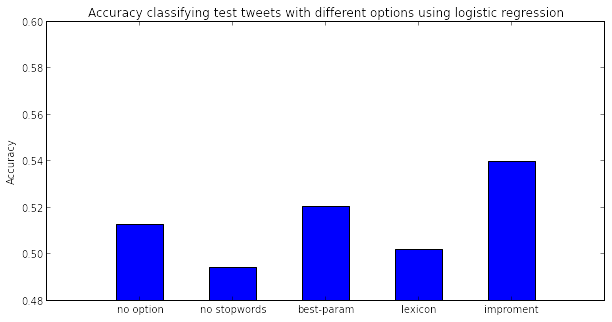

In [63]:
def accuracy_graph(preds, truths):
    acc_list = []
    for idx in xrange(len(preds)):
        acc_list.append(accuracy_score(truths[idx], preds[idx]))
        
    plt.figure(figsize=(10,5))
    p = plt.bar([num+1.0 for num in range(len(preds))], acc_list, 0.5, align='center')
    plt.ylabel('Accuracy')
    plt.title('Accuracy classifying test tweets with different options using logistic regression')
    plt.ylim(0.48)
    plt.xticks([num+1.0 for num in range(len(preds))], 
               ('no option','no stopwords', 'best-param', 'lexicon', 'improment'))
    plt.show()

accuracy_graph(predictions_, truths_)

From the chart above, if we take "no-option" bar as baseline, options that applies best classifier parameter and improvement methods improve the performance as expected. However, "no stopwords" bar and "lexicon" bar does not perform as expected like in development set where the "no-option" accuracy is 50.02% and "stopwords + lexicon" accuracy is 50.46%. 

From now on, we are confirmed that our improvement methods indeed improve the result. But we don't know if the "no stopwords" option and "lexicon" options really decrease the accuracy on test set, so for simplicity, we plot the accuracy with all options and options that only includes best classifier parameters and our improvement methods. 

Accuracy of two groups: 0.553403431101 (all options), 0.549529607084 (2+4 options)


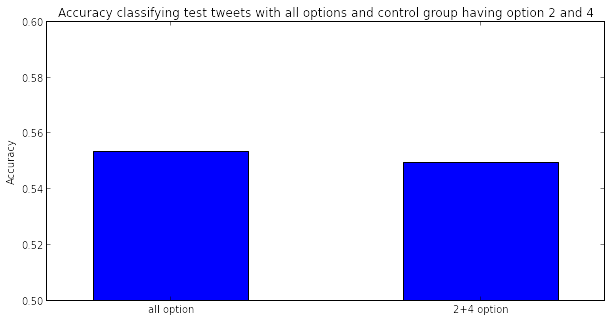

In [64]:
''' Final test of all major options:
    1. Preprocessing option: Remove stopwords in BOW from training set
    2. Tuning option: C=0.1, max_iter=100 in logistic regression classifier
    3. Lexicon option: Use all 4 lexicons 
    4. Improvement option: Improment method 1 + improvement method 3
    and control group that only have option 2 and 4.
'''
def accuracy_with_all_options(train_tweets, 
                              train_labels, 
                              test_tweets, 
                              test_labels, 
                              lexicon_tuples=[], 
                              stopwords=set()):
    train_sent_dicts, train_sent_labels, _ = get_sent_dicts_label(train_tweets, 
                                                                  train_labels,  
                                                                  lexicon_tuples,
                                                                  stopwords=stopwords,
                                                                 )
    test_sent_dicts, _, test_tweet_sent_map = get_sent_dicts_label(test_tweets,
                                                                  test_labels, 
                                                                  lexicon_tuples,
                                                                  trainset=False,
                                                                  )
    vectorizor = DictVectorizer()
    train_sent_x = vectorizer.fit_transform(train_sent_dicts)
    test_sent_x = vectorizer.transform(test_sent_dicts)
    # use best tuning options
    final_clf = LogisticRegression(solver='lbfgs',
                                      C=0.1,
                                      max_iter=100,
                                      multi_class='multinomial')

    final_clf.fit(train_sent_x, train_sent_labels)
    pred = final_clf.predict(test_sent_x)
    test_tweet_preds = []
    for idx in xrange(len(test_labels)):
        test_tweet_preds.append(get_tweet_label_from_sents(idx, pred, test_tweet_sent_map))
    
    return accuracy_score(test_labels, test_tweet_preds), test_tweet_preds, test_labels

acc_all_options, pred, labels = accuracy_with_all_options(train_tweets, train_labels, 
                                            test_tweets, test_labels,
                                            lexicon_tuples[1:], 
                                            stopwords)
predictions_.append(pred)
truths_.append(labels)
acc_control, pred, labels = accuracy_with_all_options(train_tweets, train_labels, 
                                                      test_tweets, test_labels)
predictions_.append(pred)
truths_.append(labels)

acc_list = [acc_all_options, acc_control]
print 'Accuracy of two groups: %s (all options), %s (2+4 options)' % (acc_list[0], acc_list[1])

plt.figure(figsize=(10,5))
p = plt.bar([num+1.0 for num in range(len(acc_list))], acc_list, 0.5, align='center')
plt.ylabel('Accuracy')
plt.title('Accuracy classifying test tweets with all options and control group having option 2 and 4')
plt.ylim(0.5)
plt.xticks([num+1.0 for num in range(len(acc_list))], 
            ('all option','2+4 option'))
plt.show()

From now on, we still cannot tell which solution is better, because the results are so close and the risk is not only measured by accuracy, we want to view it on more generalized metrics, precision, recall, f1-score. 

Next, we produce the table (classification report) that contain precision, recall, f1-score with respect to each case and macro-averaged f1-score. Each result include a table and macro-averaged f1-score. Each result respond to a specific case. Cases are numbered as the following order and are described later with the same order. 

0. No options (baseline)
1. Preprocessing option: Remove stopwords in BOW from training set
2. Tuning with best classifier param options: C=0.1, max_iter=100 in logistic regression classifier
3. Lexicon option: Use all 4 lexicons 
4. Improvement option: Improment method 1 + improvement method 3
5. All obove (2+3+4+5) options 
6. Controlled options (3+5)

In [65]:
from sklearn.metrics import f1_score, classification_report

for idx in range(len(predictions_)):
    print '///////////////////////Case %s//////////////////////////' % (idx+1)
    print 'Evaluation Table:'
    print classification_report(truths_[idx], predictions_[idx])
    print 'Macro-averaged f1 score is: %s' % f1_score(truths_[idx], predictions_[idx], average='macro')

///////////////////////Case 1//////////////////////////
Evaluation Table:
             precision    recall  f1-score   support

         -1       0.37      0.43      0.40       290
          0       0.43      0.63      0.51       625
          1       0.75      0.46      0.57       892

avg / total       0.58      0.51      0.52      1807

Macro-averaged f1 score is: 0.491331916602
///////////////////////Case 2//////////////////////////
Evaluation Table:
             precision    recall  f1-score   support

         -1       0.35      0.36      0.36       290
          0       0.41      0.63      0.50       625
          1       0.73      0.44      0.55       892

avg / total       0.56      0.49      0.50      1807

Macro-averaged f1 score is: 0.466989183405
///////////////////////Case 3//////////////////////////
Evaluation Table:
             precision    recall  f1-score   support

         -1       0.38      0.33      0.35       290
          0       0.43      0.70      0.53       

From now on, according to f1-score (micro & macro), "case 5" and "case 6" are the top 2 best. Since results of the best two cases are very close, it is not that convincing to select the best from the two. From my own opinion, if I am sure that the label represents polarity, I will use "case 5" as final model, because it adds polarity lexicon features.

**Reflections**

After the implementation of this assignment, I reviewed the preprocessing of NLP problem step by step:
* Remove unwanted formatting
* Segment sentences
* Tokenize words
* Normalize words (lemmatization)
* Remove unwanted words (stemming)

I also reinforce the understanding of text classification, such as using term frequency to represent documents, BOW feature transformation, building term-document matrix, etc. The process of comparison of different classifiers gives me direct experiences of how to better using sci-kit package. 

The exploration of using lexicon to analyse sentiment behind documents enhances my understanding of sentiment analtics capabilities, including how to generate lexicons with hands-on packages (like sentiwordnet), how to evaluate them. 

The final evaluation methods offer me potential angles to evaluate errors, especially multi-class classification problem and NLP related thinking method (like transforming document-based BOW features to sentence-based BOW features).
